# Default of Credit Card Clients Dataset

## Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
df.rename(columns={'PAY_0': 'PAY_1', 'default.payment.next.month': 'default'}, inplace=True)

In [4]:
y = df['default']
X = df.drop('default', axis=1)

## Data Wrangling

Analyze the correlation between each feature.

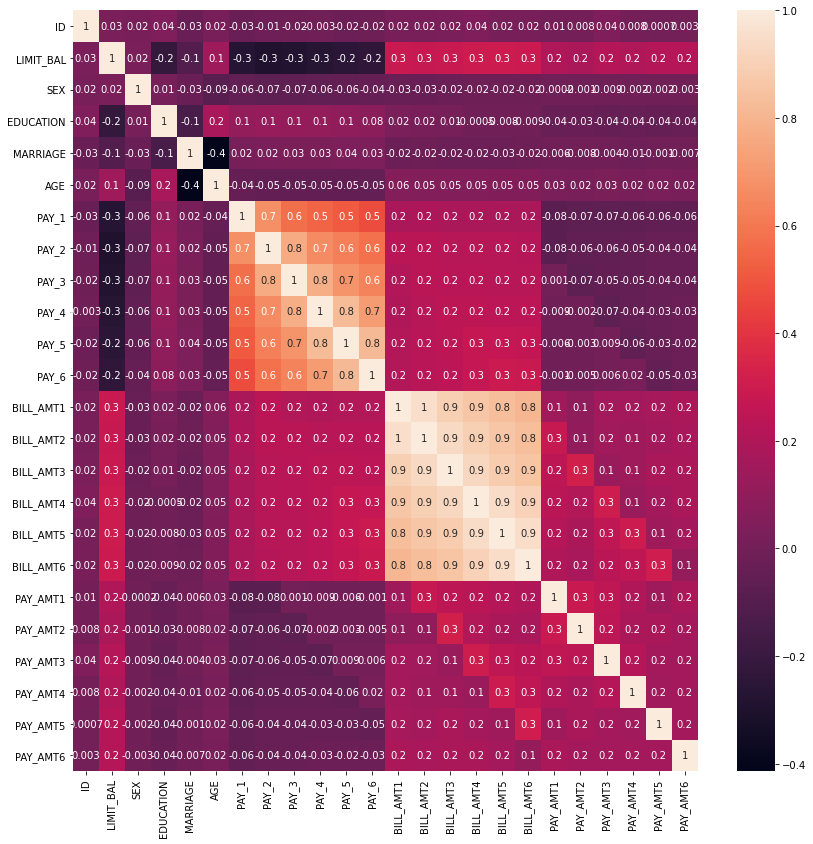

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 14))
sns.heatmap(X.corr(), annot=True, fmt='.1g')
plt.show()

It seems *BILL_AMT1*-*BILL_AMT6* are strongly correlated to each other. Let's apply PCA to these columns.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

bill_amt_columns = [f'BILL_AMT{i}' for i in range(1, 7)]

standard_scaler = StandardScaler()
n_components = 2
pca = PCA(n_components=n_components)
scaled_columns = standard_scaler.fit_transform(X[bill_amt_columns])
pca.fit(scaled_columns)
print('PCA total explained variance ratio:', sum(pca.explained_variance_ratio_))

PCA total explained variance ratio: 0.9565392265910996


In [7]:
transformed_columns = pca.transform(scaled_columns)
column_names = [f'BILL_AMT_PCA{i}' for i in range(1, n_components + 1)]
transformed_columns = pd.DataFrame(transformed_columns, columns=column_names)
X = X.merge(transformed_columns, left_index=True, right_index=True)
X.drop([f'BILL_AMT{i}' for i in range(1, 7)], axis=1, inplace=True)
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_PCA1,BILL_AMT_PCA2
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0,-1.611148,0.012479
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0,-1.547595,-0.062344
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,-1.035874,0.011256
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,-0.250712,0.174374
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,-0.968951,-0.213032


Split the dataset into train and test parts.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Train Model

We are going to use a random forest classifier.

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=300)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

## Test Model

In [11]:
accuracy = random_forest_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8241
